In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [20]:
# Westbound traffic volume on the I-94 between Minneapolis and St-Paul in Minnesota, starting on September 29, 2016, at 5pm
traffic_df = pd.read_csv('../data/hourly_traffic.csv', parse_dates=['date_time'])

# Minimum daily temperature in a city in Australia during the entire year of 1981
temp_df = pd.read_csv('../data/daily_min_temp.csv', parse_dates=['Date'])

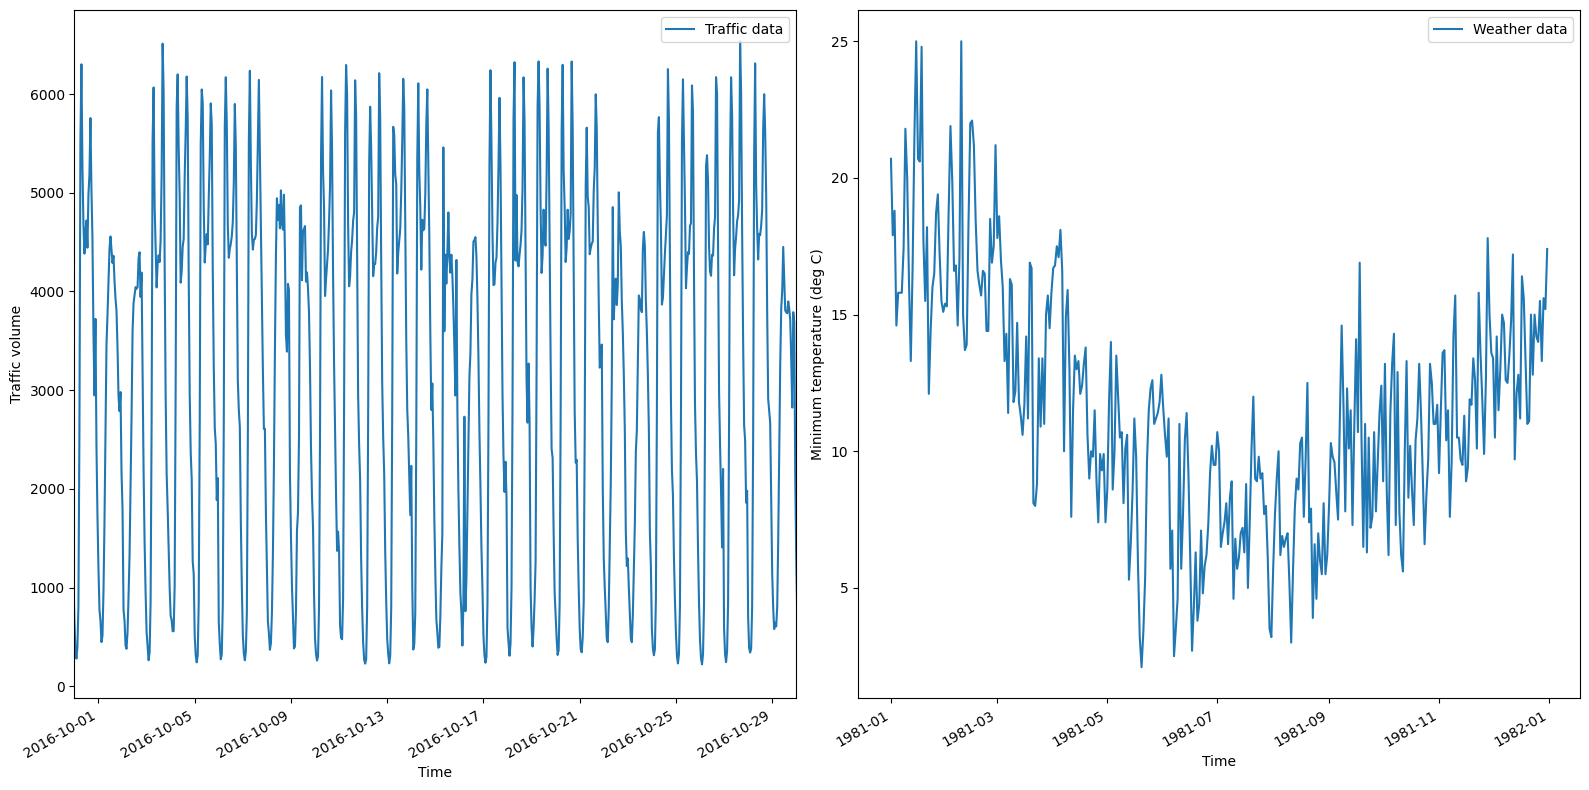

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharex=False)

ax1.plot(traffic_df['date_time'], traffic_df['traffic_volume'], label='Traffic data')
ax1.set_xlabel('Time')
ax1.set_ylabel('Traffic volume')
ax1.set_xlim([datetime.date(2016, 9, 30), datetime.date(2016, 10, 30)])
ax1.legend(loc=1)

ax2.plot(temp_df['Date'], temp_df['Temp'], label='Weather data')
ax2.set_xlabel('Time')
ax2.set_ylabel('Minimum temperature (deg C)')
ax2.legend(loc=1)
ax2.tick_params(axis='both', which='both')

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH03_codefig01.png', dpi=300)

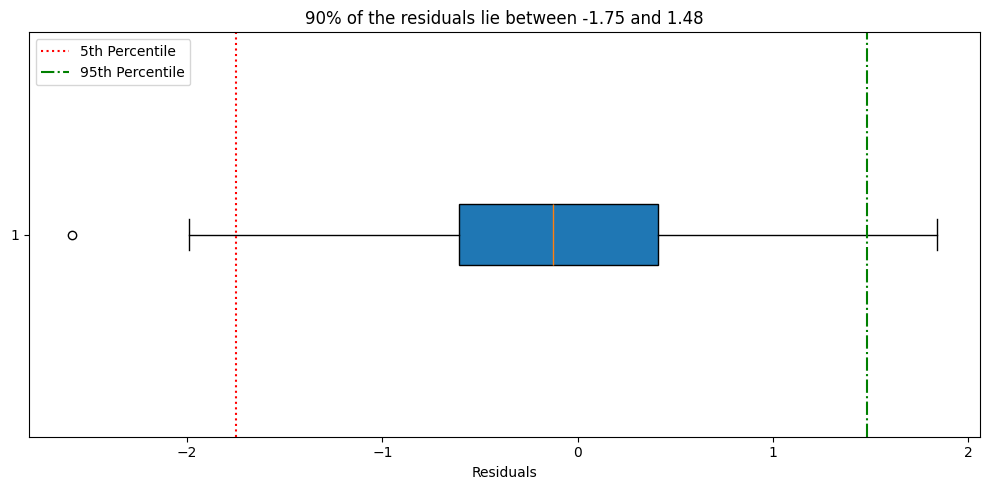

In [22]:
from statsmodels.tsa.arima.model import ARIMA

# Generate a time series dataset
np.random.seed(42)
n = 100
time_series_data = np.cumsum(np.random.normal(0, 1, n))

# Fit ARIMA model
model = ARIMA(time_series_data, order=(1, 1, 1))
fitted_model = model.fit()

# Get the residuals
residuals = fitted_model.resid

# Get the 5th and 95th percentiles
lower_bound = round(np.percentile(residuals, 5),2)
upper_bound = round(np.percentile(residuals, 95),2)

# Plot residuals
plt.figure(figsize=(10, 5))
plt.boxplot(residuals, vert=False, patch_artist=True)
plt.title(f'90% of the residuals lie between {lower_bound} and {upper_bound}')
plt.xlabel('Residuals')
plt.axvline(lower_bound, color='red', linestyle=':', label='5th Percentile')
plt.axvline(upper_bound, color='green', linestyle='-.', label='95th Percentile')
plt.legend()
plt.tight_layout()

plt.savefig('figures/CH03_codefig02.png', dpi=300)

## Forecasting with TimeGPT

In [3]:
df = pd.read_csv('../data/walmart_sales_small.csv', parse_dates=['Date'])

df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
df.tail()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
567,4,2012-09-28,2027620.23,0,71.74,3.666,131.043000,4.077
568,4,2012-10-05,2209835.43,0,63.07,3.620,131.075667,3.879
569,4,2012-10-12,2133026.07,0,57.11,3.603,131.108333,3.879
570,4,2012-10-19,2097266.85,0,64.46,3.610,131.149968,3.879
571,4,2012-10-26,2149594.46,0,63.64,3.514,131.193097,3.879


In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from nixtla import NixtlaClient

nixtla_client = NixtlaClient()

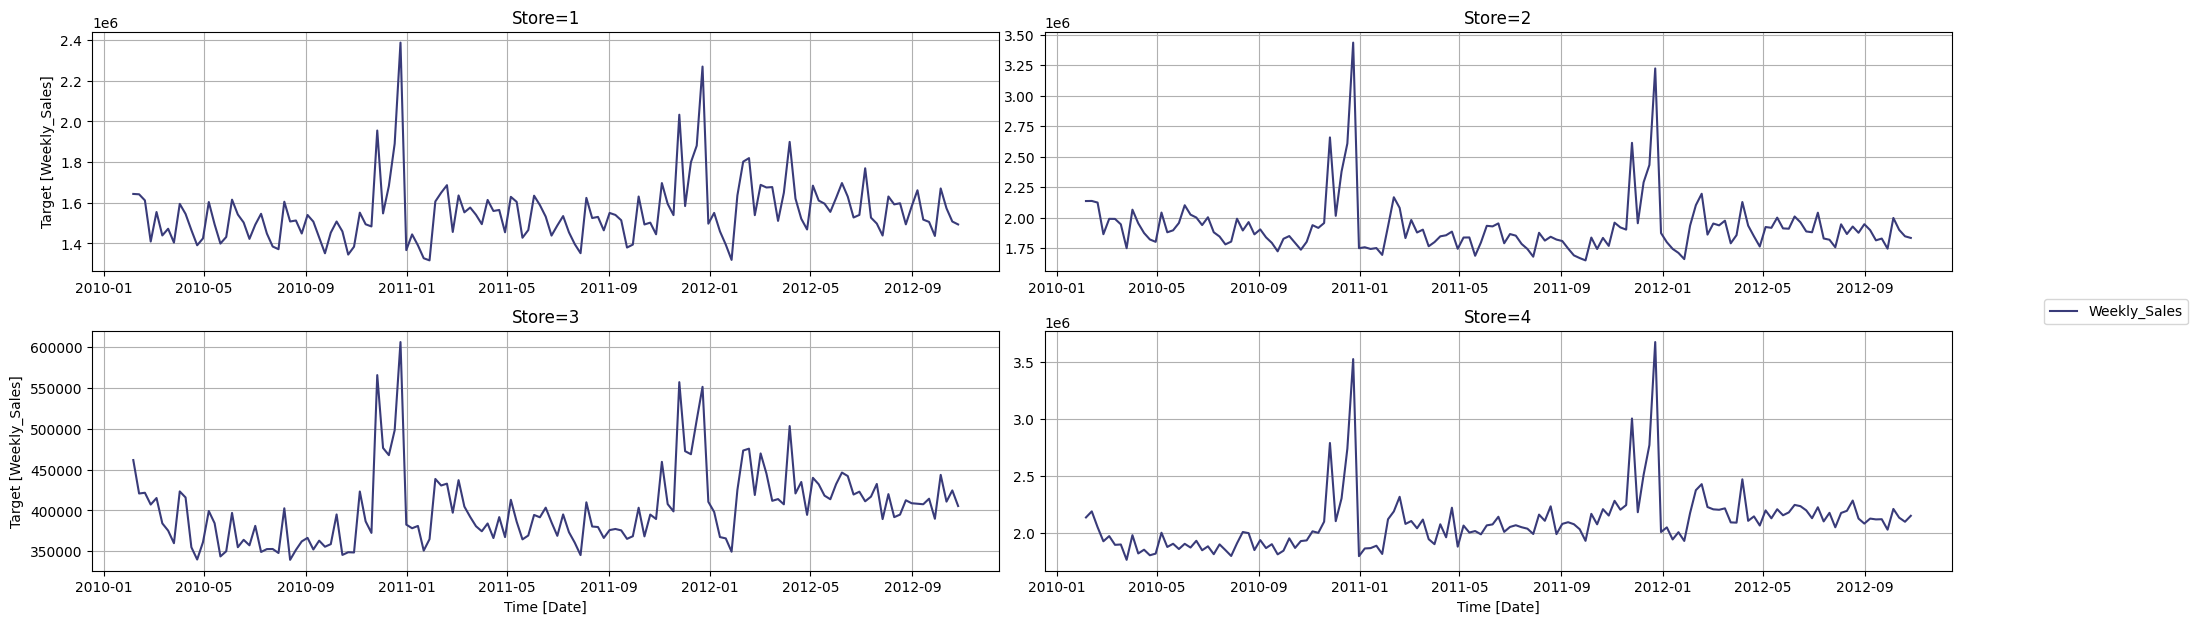

In [26]:
nixtla_client.plot(df, 
                   time_col='Date', 
                   id_col='Store', 
                   target_col='Weekly_Sales')

In [27]:
preds_df = nixtla_client.forecast(
    df,
    h=8,
    level=[80],
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


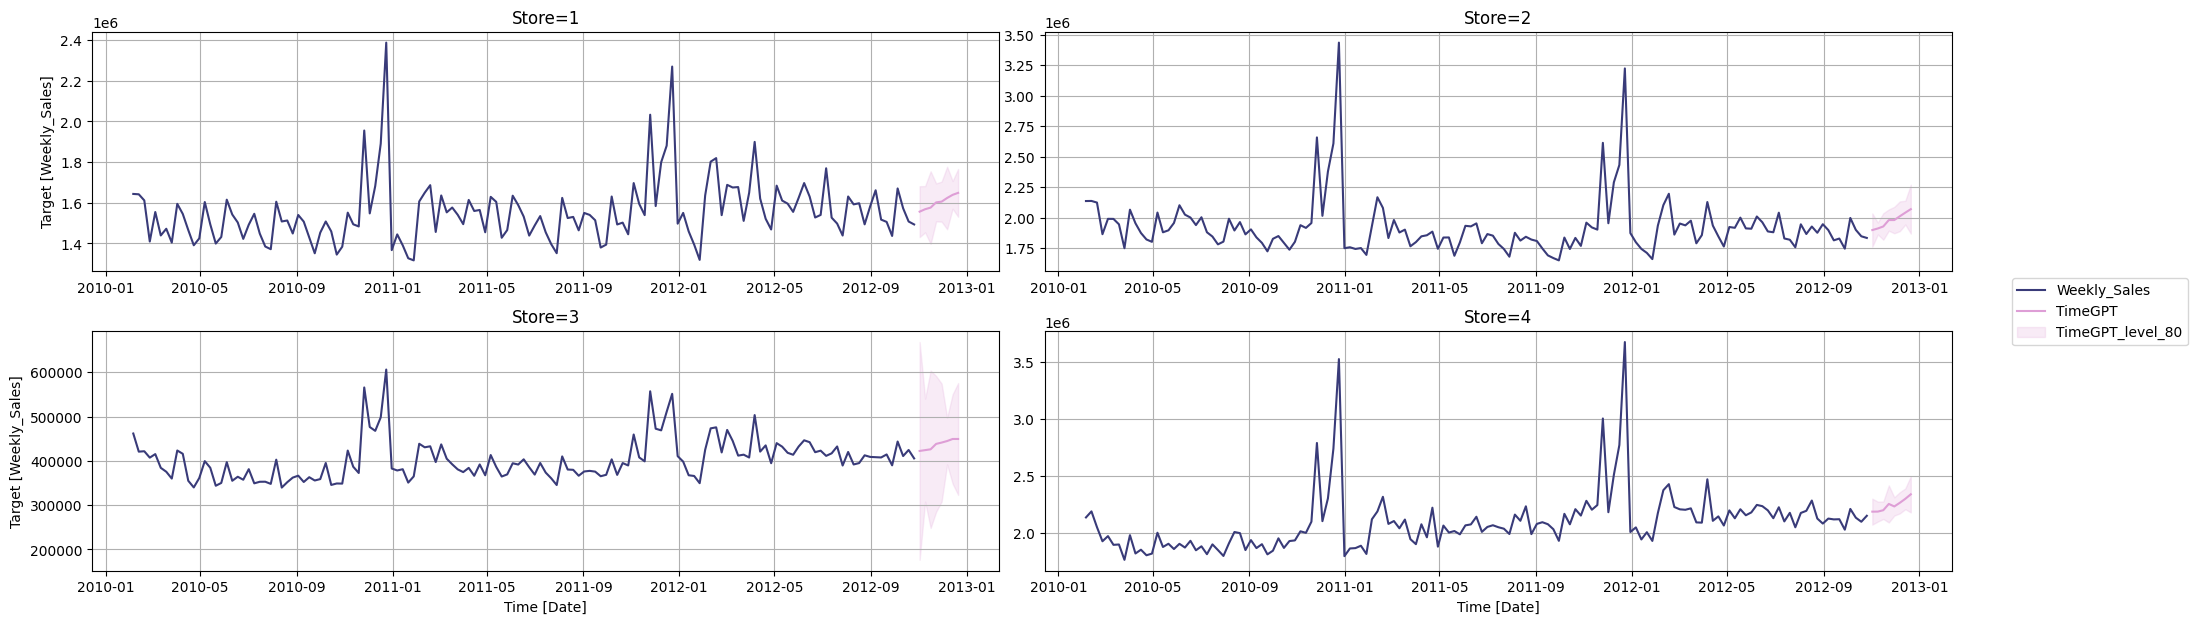

In [28]:
nixtla_client.plot(df, 
                   preds_df, 
                   level=[80], 
                   time_col='Date', 
                   id_col='Store', 
                   target_col='Weekly_Sales')

### Evaluate performance

In [29]:
test_df = df.groupby('Store').tail(8)
input_df = df.drop(test_df.index).reset_index(drop=True)

In [30]:
preds = nixtla_client.forecast(
    input_df,
    h=8,
    level=[80],
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [31]:
eval_df = test_df.copy()

preds['Date'] = pd.to_datetime(preds['Date'])

eval_df = pd.merge(eval_df, preds, 'left', ['Store', 'Date'])

In [32]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    models=['TimeGPT'],
    target_col='Weekly_Sales',
    id_col='Store'
)

avg_metrics = evaluation.groupby('metric')['TimeGPT'].mean()

avg_metrics

metric
mae      54047.120430
smape        0.017553
Name: TimeGPT, dtype: float64

### Fine-tuning TimeGPT

In [38]:
sub_df = df[df['Store'] == 1]

test_df = sub_df.tail(8)
input_df = sub_df.drop(test_df.index).reset_index(drop=True)

In [39]:
preds = nixtla_client.forecast(
    df=input_df,
    h=8,
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [40]:
finetune_preds = nixtla_client.forecast(
    df=input_df,
    h=8,
    finetune_steps=10,
    finetune_loss='mae',
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [41]:
eval_df = test_df.copy()

preds['Date'] = pd.to_datetime(finetune_preds['Date'])

finetune_preds['Date'] = pd.to_datetime(finetune_preds['Date'])
finetune_preds.rename(columns={"TimeGPT": "TimeGPT-finetuned"}, inplace=True)

eval_df = pd.merge(eval_df, finetune_preds, 'left', ['Store', 'Date'])
eval_df = pd.merge(eval_df, preds, 'left', ['Store', 'Date'])

eval_df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,TimeGPT-finetuned,TimeGPT
0,1,2012-09-07,1661767.33,1,83.96,3.730,222.439015,6.908,1558124.250,1562177.875
1,1,2012-09-14,1517428.87,0,74.97,3.717,222.582019,6.908,1560675.125,1559482.625
2,1,2012-09-21,1506126.06,0,69.87,3.721,222.781839,6.908,1549928.500,1544988.625
3,1,2012-09-28,1437059.26,0,76.08,3.666,222.981658,6.908,1553688.625,1556686.000
4,1,2012-10-05,1670785.97,0,68.55,3.617,223.181477,6.573,1576523.500,1586022.500


In [43]:
evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    models=['TimeGPT', 'TimeGPT-finetuned'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

,Store,metric,TimeGPT,TimeGPT-finetuned
0,1,mae,75237.348750,70822.020625
1,1,smape,0.024143,0.022763


### Forecasting with exogenous variables

In [45]:
future_exog = test_df[['Store', 'Date', 'Holiday_Flag']]
future_exog

,Store,Date,Holiday_Flag
135,1,2012-09-07,1
136,1,2012-09-14,0
137,1,2012-09-21,0
138,1,2012-09-28,0
139,1,2012-10-05,0
140,1,2012-10-12,0
141,1,2012-10-19,0
142,1,2012-10-26,0


#### Forecast fuel price and CPI

In [47]:
fuel_preds = nixtla_client.forecast(
    df=input_df,
    h=8,
    time_col='Date',
    id_col='Store',
    target_col='Fuel_Price'
)
fuel_preds.rename(columns={"TimeGPT": "Fuel_Price"}, inplace=True)

cpi_preds = nixtla_client.forecast(
    df=input_df,
    h=8,
    time_col='Date',
    id_col='Store',
    target_col='CPI'
)
cpi_preds.rename(columns={"TimeGPT": "CPI"}, inplace=True)

fuel_preds['Date'] = pd.to_datetime(finetune_preds['Date'])
cpi_preds['Date'] = pd.to_datetime(finetune_preds['Date'])

future_exog = pd.merge(future_exog, fuel_preds, 'left', ['Store', 'Date'])
future_exog = pd.merge(future_exog, cpi_preds, 'left', ['Store', 'Date'])

future_exog

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,Store,Date,Holiday_Flag,Fuel_Price,CPI
0,1,2012-09-07,1,3.612594,222.329147
1,1,2012-09-14,0,3.597838,222.339767
2,1,2012-09-21,0,3.555918,222.391617
3,1,2012-09-28,0,3.487907,222.552368
4,1,2012-10-05,0,3.454414,222.745605
5,1,2012-10-12,0,3.455894,222.828339
6,1,2012-10-19,0,3.466672,222.905563
7,1,2012-10-26,0,3.468813,222.983917


In [48]:
preds_exog = nixtla_client.forecast(
    df=input_df,
    X_df=future_exog,
    h=8,
    finetune_steps=10,
    finetune_loss='mae',
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Using the following exogenous variables: Holiday_Flag, Fuel_Price, CPI
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


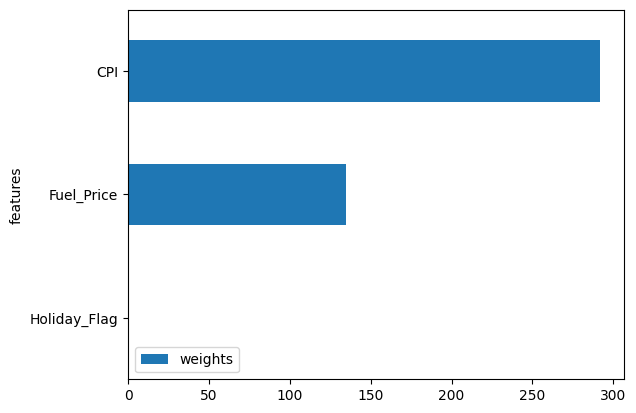

In [51]:
nixtla_client.weights_x.plot.barh(x='features', y='weights');

In [49]:
eval_df = test_df.copy()

preds_exog['Date'] = pd.to_datetime(preds_exog['Date'])

eval_df = pd.merge(eval_df, preds_exog, 'left', ['Store', 'Date'])

evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    models=['TimeGPT'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

,Store,metric,TimeGPT
0,1,mae,68255.90962
1,1,smape,0.02195


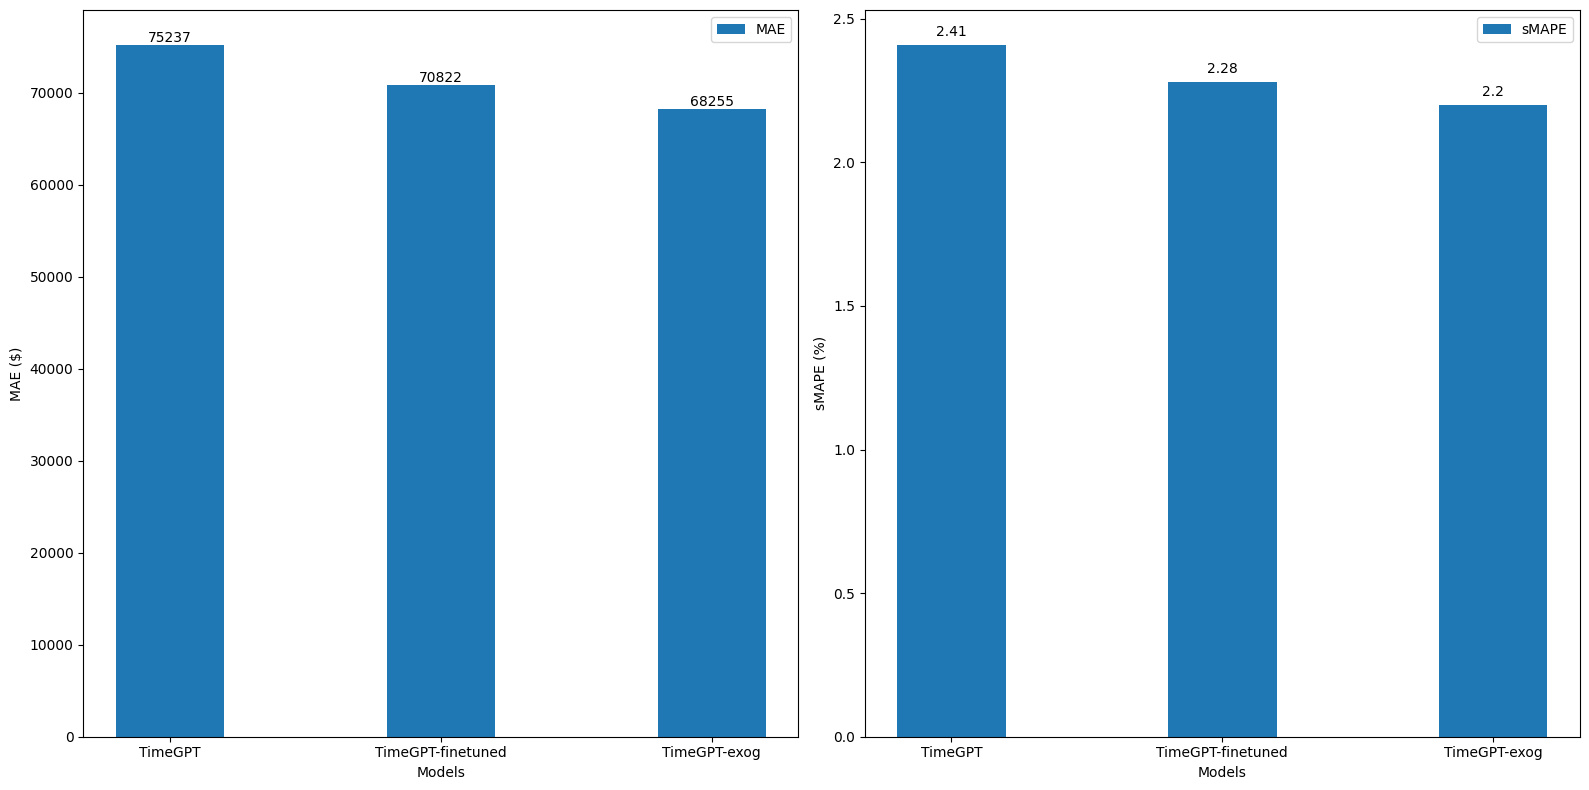

In [58]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['TimeGPT', 'TimeGPT-finetuned', 'TimeGPT-exog']
y_mae = [75237, 70822, 68255]
y_smape = [2.41, 2.28, 2.20]

ax1.bar(x, y_mae, width=0.4, label='MAE')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAE ($)')
ax1.legend()

for i, v in enumerate(y_mae):
    ax1.text(x=i, y=v+300, s=str(v), ha='center')

ax2.bar(x, y_smape, width=0.4, label='sMAPE')
ax2.set_xlabel('Models')
ax2.set_ylabel('sMAPE (%)')
ax2.legend()

for i, v in enumerate(y_smape):
    ax2.text(x=i, y=v+.03, s=str(v), ha='center')

plt.tight_layout()
plt.savefig("figures/CH03_codefig06.png", dpi=300)

### Cross-validation with TimeGPT

In [59]:
cv_df = nixtla_client.cross_validation(
    df=sub_df,
    h=8,
    n_windows=4,
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)

cv_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Using the following exogenous variables: Holiday_Flag, Temperature, Fuel_Price, CPI, Unemployment
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


,Store,Date,cutoff,Weekly_Sales,TimeGPT
0,1,2012-03-23,2012-03-16,1511068.07,1.646528e+06
1,1,2012-03-30,2012-03-16,1649604.63,1.640640e+06
2,1,2012-04-06,2012-03-16,1899676.88,1.645306e+06
3,1,2012-04-13,2012-03-16,1621031.70,1.640180e+06
4,1,2012-04-20,2012-03-16,1521577.87,1.637466e+06


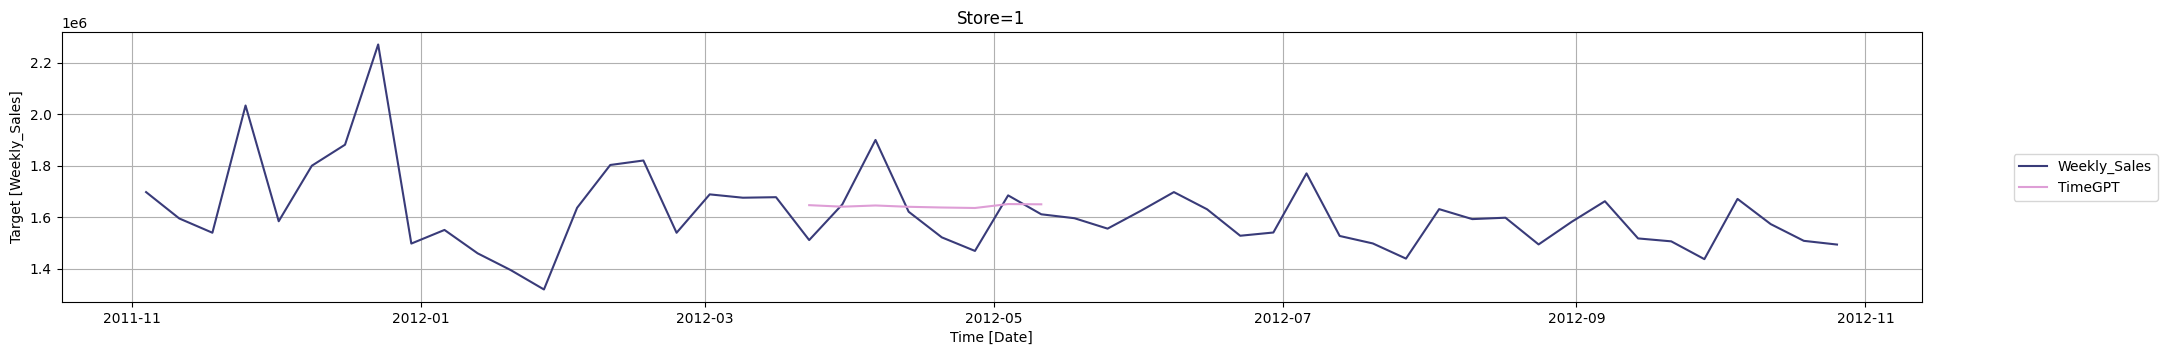

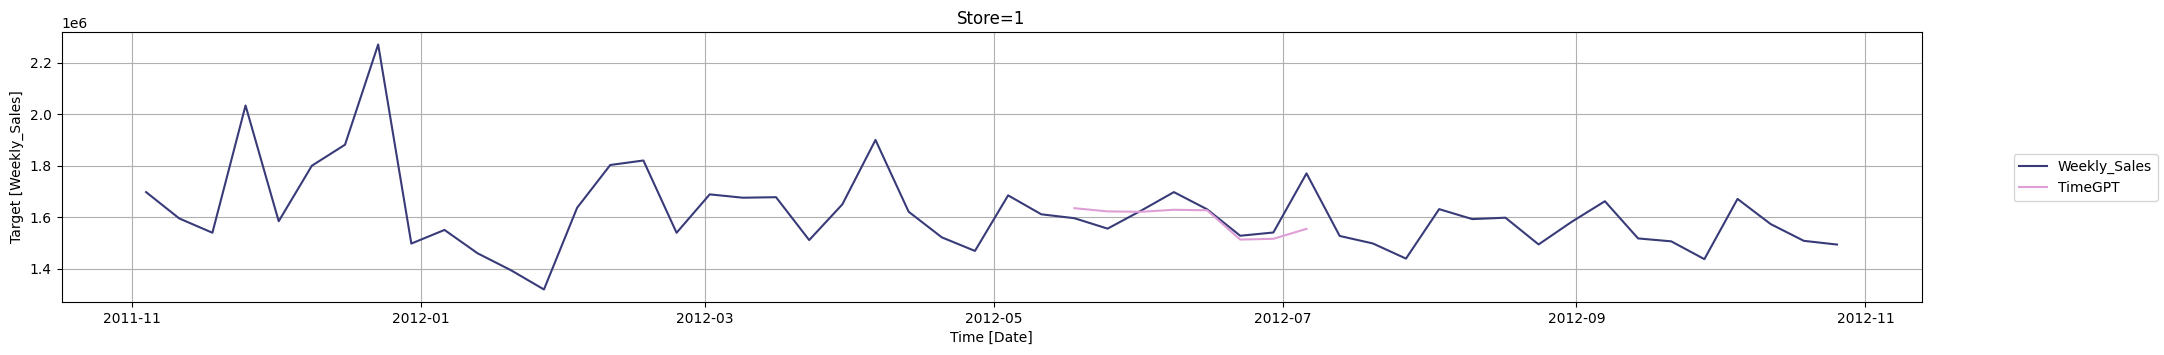

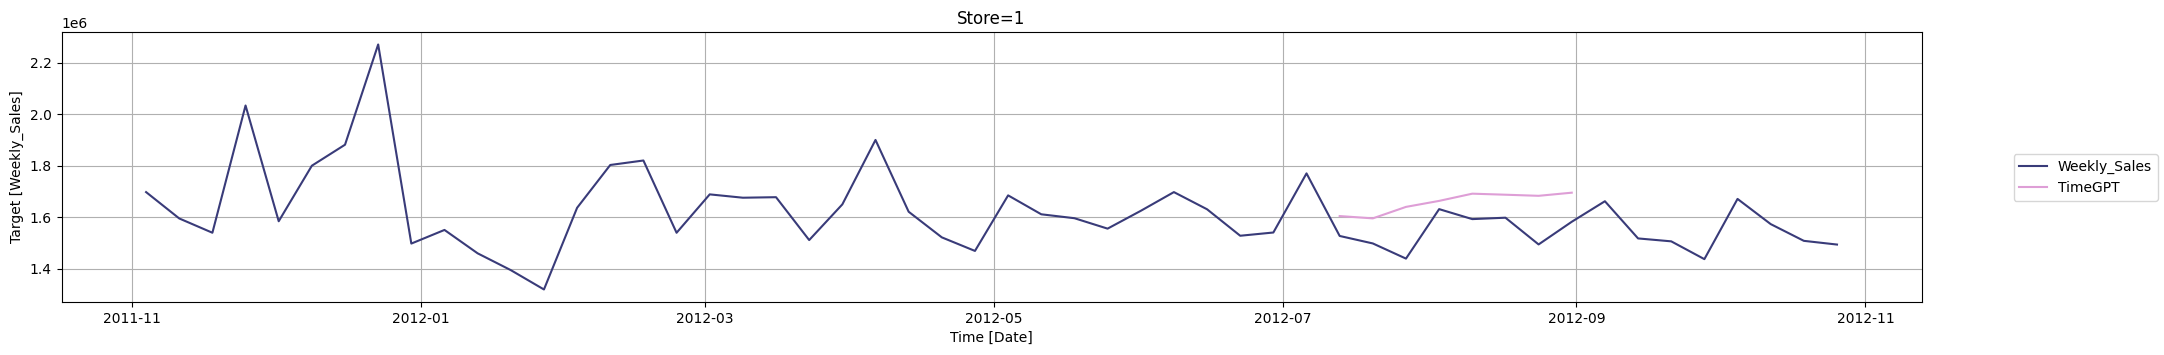

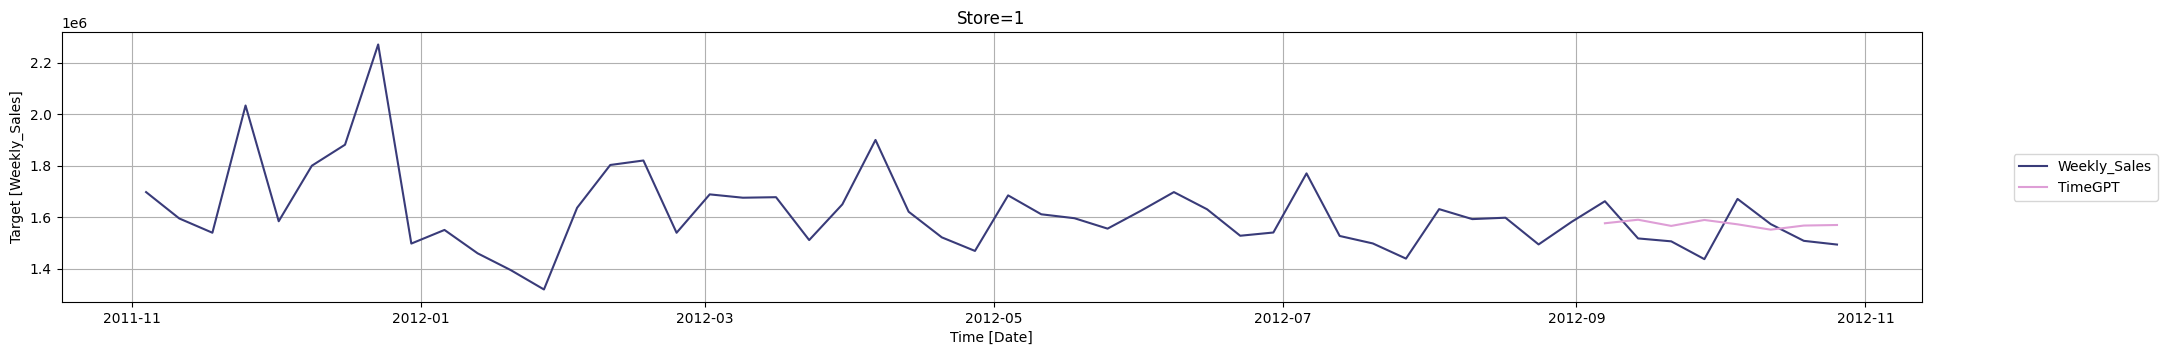

In [67]:
from IPython.display import display

cutoffs = cv_df['cutoff'].unique()

for cutoff in cutoffs:
    fig = nixtla_client.plot(
        sub_df.tail(52),
        cv_df.query("cutoff == @cutoff").drop(columns=['cutoff', 'Weekly_Sales']),
        models=['TimeGPT'],
        time_col='Date',
        id_col='Store',
        target_col='Weekly_Sales'       
    )

    display(fig)

In [68]:
evaluation = evaluate(
    cv_df,
    metrics=[mae, smape],
    models=['TimeGPT'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

,Store,metric,TimeGPT
0,1,mae,85365.011306
1,1,smape,0.026633


### Long-horizon forecasting with TimeGPT

In [74]:
test_df = sub_df.tail(52)
input_df = sub_df.drop(test_df.index).reset_index(drop=True)

In [75]:
long_preds = nixtla_client.forecast(
    df=input_df,
    h=52,
    model='timegpt-1-long-horizon',
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)
long_preds.rename(columns={"TimeGPT": "TimeGPT-long"}, inplace=True)

short_preds = nixtla_client.forecast(
    df=input_df,
    h=52,
    time_col='Date',
    id_col='Store',
    target_col='Weekly_Sales'
)
short_preds.rename(columns={"TimeGPT": "TimeGPT-short"}, inplace=True)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [76]:
eval_df = test_df.copy()

long_preds['Date'] = pd.to_datetime(long_preds['Date'])
short_preds['Date'] = pd.to_datetime(short_preds['Date'])

eval_df = pd.merge(eval_df, long_preds, 'left', ['Store', 'Date'])
eval_df = pd.merge(eval_df, short_preds, 'left', ['Store', 'Date'])

evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    models=['TimeGPT-long', 'TimeGPT-short'],
    target_col='Weekly_Sales',
    id_col='Store'
)

evaluation

,Store,metric,TimeGPT-long,TimeGPT-short
0,1,mae,111408.019712,106306.696731
1,1,smape,0.033728,0.032078


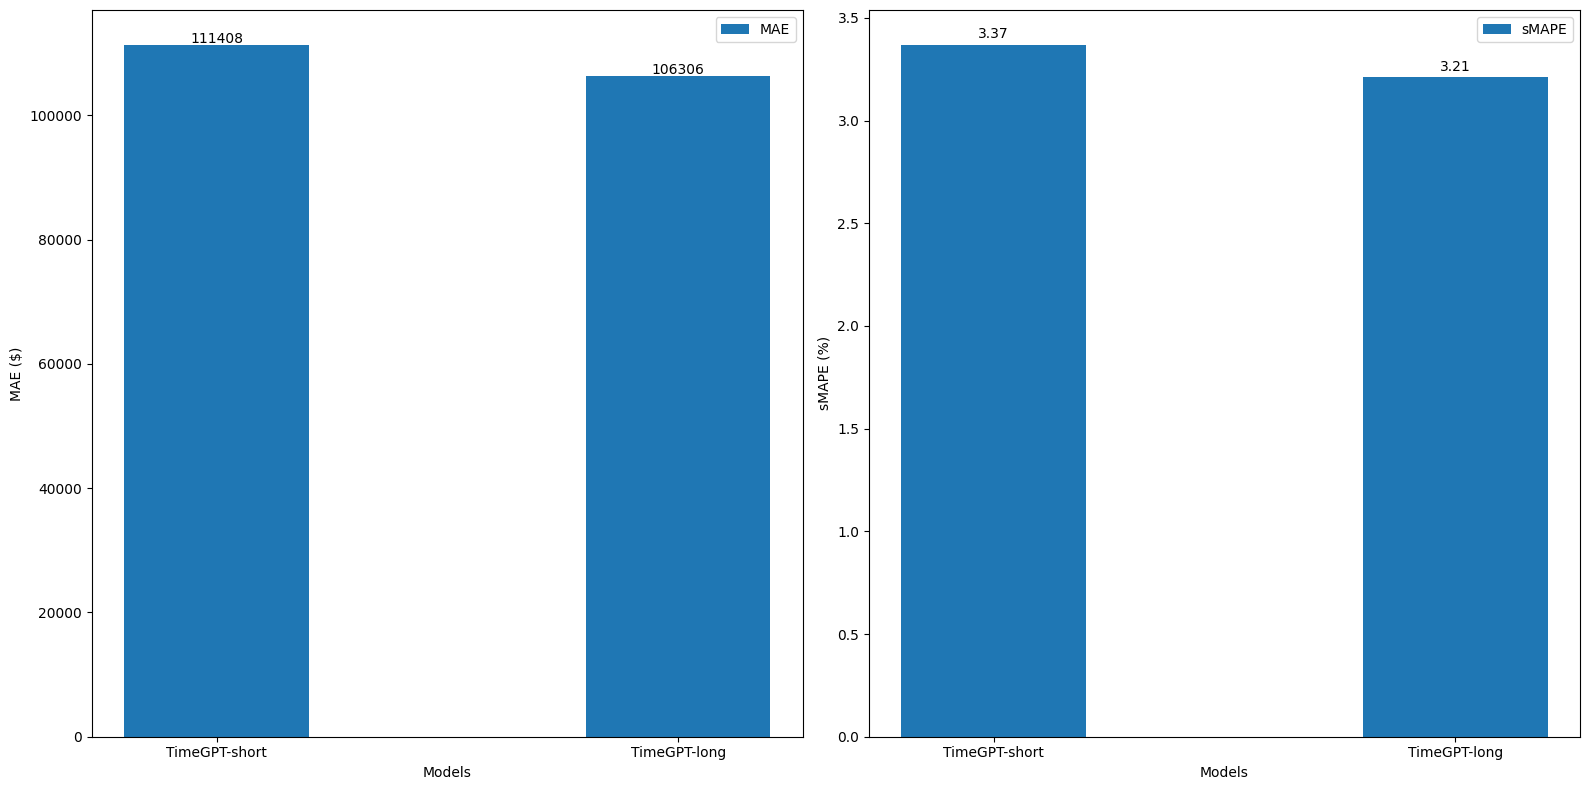

In [77]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['TimeGPT-short', 'TimeGPT-long']
y_mae = [111408, 106306]
y_smape = [3.37, 3.21]

ax1.bar(x, y_mae, width=0.4, label='MAE')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAE ($)')
ax1.legend()

for i, v in enumerate(y_mae):
    ax1.text(x=i, y=v+300, s=str(v), ha='center')

ax2.bar(x, y_smape, width=0.4, label='sMAPE')
ax2.set_xlabel('Models')
ax2.set_ylabel('sMAPE (%)')
ax2.legend()

for i, v in enumerate(y_smape):
    ax2.text(x=i, y=v+.03, s=str(v), ha='center')

plt.tight_layout()
plt.savefig("figures/CH03_codefig08.png", dpi=300)

## Anomaly detection with TimeGPT

In [2]:
df = pd.read_csv('../data/nyc_taxi_anomaly_daily.csv', parse_dates=['timestamp'])
df.head()

,timestamp,value,is_anomaly
0,2014-07-01,745967,0
1,2014-07-02,733640,0
2,2014-07-03,710142,0
3,2014-07-04,552565,0
4,2014-07-05,555470,0


In [3]:
df.tail()

,timestamp,value,is_anomaly
210,2015-01-27,232058,1
211,2015-01-28,621483,0
212,2015-01-29,704935,0
213,2015-01-30,800478,0
214,2015-01-31,897719,0


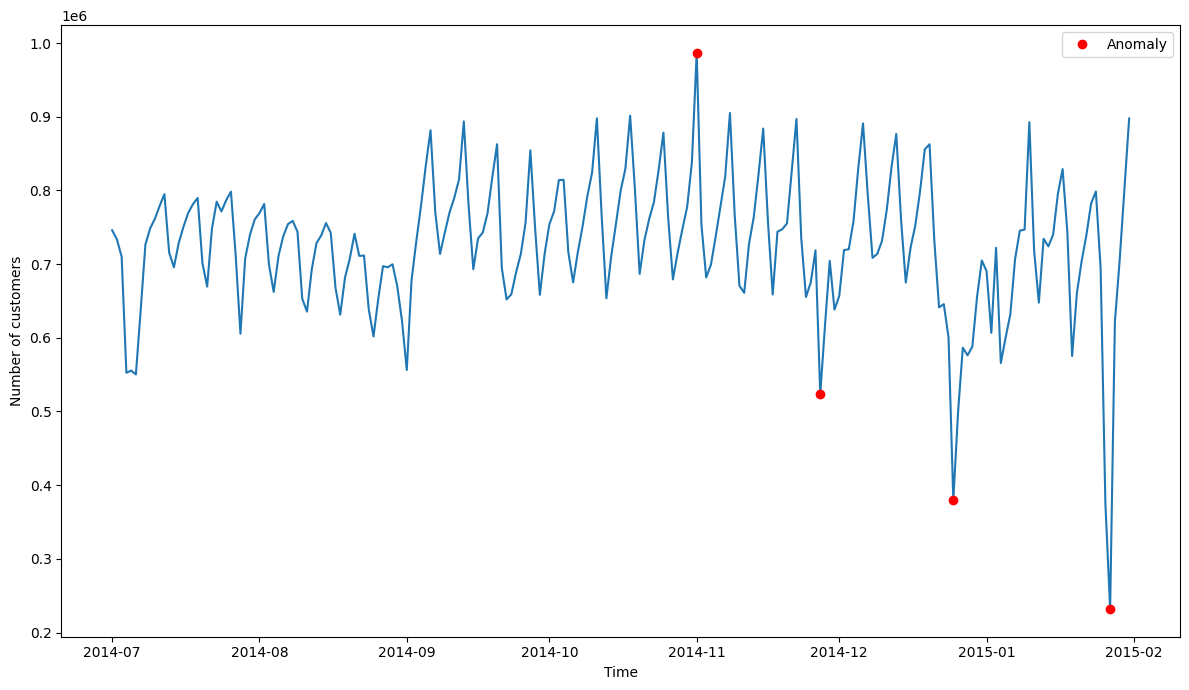

In [14]:
anomaly_df = df.loc[df['is_anomaly'] == 1]

fig, ax = plt.subplots(figsize=(12,7))

ax.plot(df['timestamp'], df['value'])
ax.plot(anomaly_df['timestamp'], anomaly_df['value'], 'o', color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('Number of customers')
ax.legend(loc='best')

plt.tight_layout()
plt.savefig("figures/CH03_codefig09.png", dpi=300)

In [15]:
anomalies_df = nixtla_client.detect_anomalies(
    df, 
    time_col='timestamp', 
    target_col='value', 
)

anomalies_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtla.nixtla_client:Using the following exogenous variables: is_anomaly


,timestamp,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
0,2014-08-03,0,473881.080641,689237.385426,904593.690211
1,2014-08-04,0,445351.135329,660707.440113,876063.744898
2,2014-08-05,0,516514.080641,731870.385426,947226.690211
3,2014-08-06,0,548726.424391,764082.729176,979439.033961
4,2014-08-07,0,554545.502516,769901.807301,985258.112086


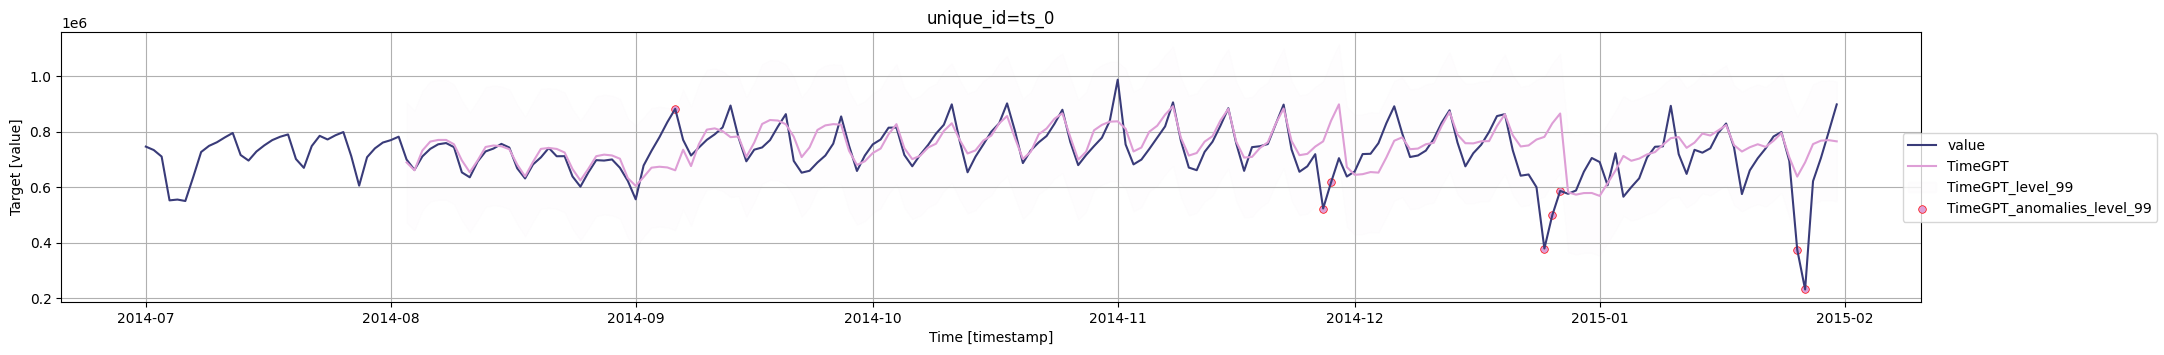

In [17]:
nixtla_client.plot(
    df, 
    anomalies_df,
    level=[99],
    time_col='timestamp', 
    target_col='value'
)

In [25]:
def evaluate_anomaly_detection(df, preds_col, actual_col):
    tp = ((df[preds_col] == 1) & (df[actual_col] == 1)).sum()
    
    tn = ((df[preds_col] == 0) & (df[actual_col] == 0)).sum()
    
    fp = ((df[preds_col] == 1) & (df[actual_col] == 0)).sum()
    
    fn = ((df[preds_col] == 0) & (df[actual_col] == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return precision, recall, f1_score

In [19]:
anomalies_df['timestamp'] = pd.to_datetime(anomalies_df['timestamp'])

anomaly_eval_df = pd.merge(anomalies_df, df, 'left', ['timestamp'])

anomaly_eval_df.head()

,timestamp,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99,value,is_anomaly
0,2014-08-03,0,473881.080641,689237.385426,904593.690211,699449,0
1,2014-08-04,0,445351.135329,660707.440113,876063.744898,662215,0
2,2014-08-05,0,516514.080641,731870.385426,947226.690211,710728,0
3,2014-08-06,0,548726.424391,764082.729176,979439.033961,737803,0
4,2014-08-07,0,554545.502516,769901.807301,985258.112086,754260,0


In [27]:
precision, recall, f1_score = evaluate_anomaly_detection(anomaly_eval_df, 'anomaly', 'is_anomaly')

print(f"Precision: {round(precision,2)}")
print(f"Recall: {round(recall,2)}")
print(f"F1-Score: {round(f1_score,2)}")

Precision: 0.38
Recall: 0.75
F1-Score: 0.5


In [28]:
anomalies_df_90 = nixtla_client.detect_anomalies(
    df,
    level=90,
    time_col='timestamp', 
    target_col='value', 
)

anomalies_df_90['timestamp'] = pd.to_datetime(anomalies_df_90['timestamp'])

anomaly_eval_df = pd.merge(anomalies_df_90, df, 'left', ['timestamp'])

precision, recall, f1_score = evaluate_anomaly_detection(anomaly_eval_df, 'anomaly', 'is_anomaly')

print(f"Precision: {round(precision,2)}")
print(f"Recall: {round(recall,2)}")
print(f"F1-Score: {round(f1_score,2)}")

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtla.nixtla_client:Using the following exogenous variables: is_anomaly


Precision: 0.29
Recall: 1.0
F1-Score: 0.44


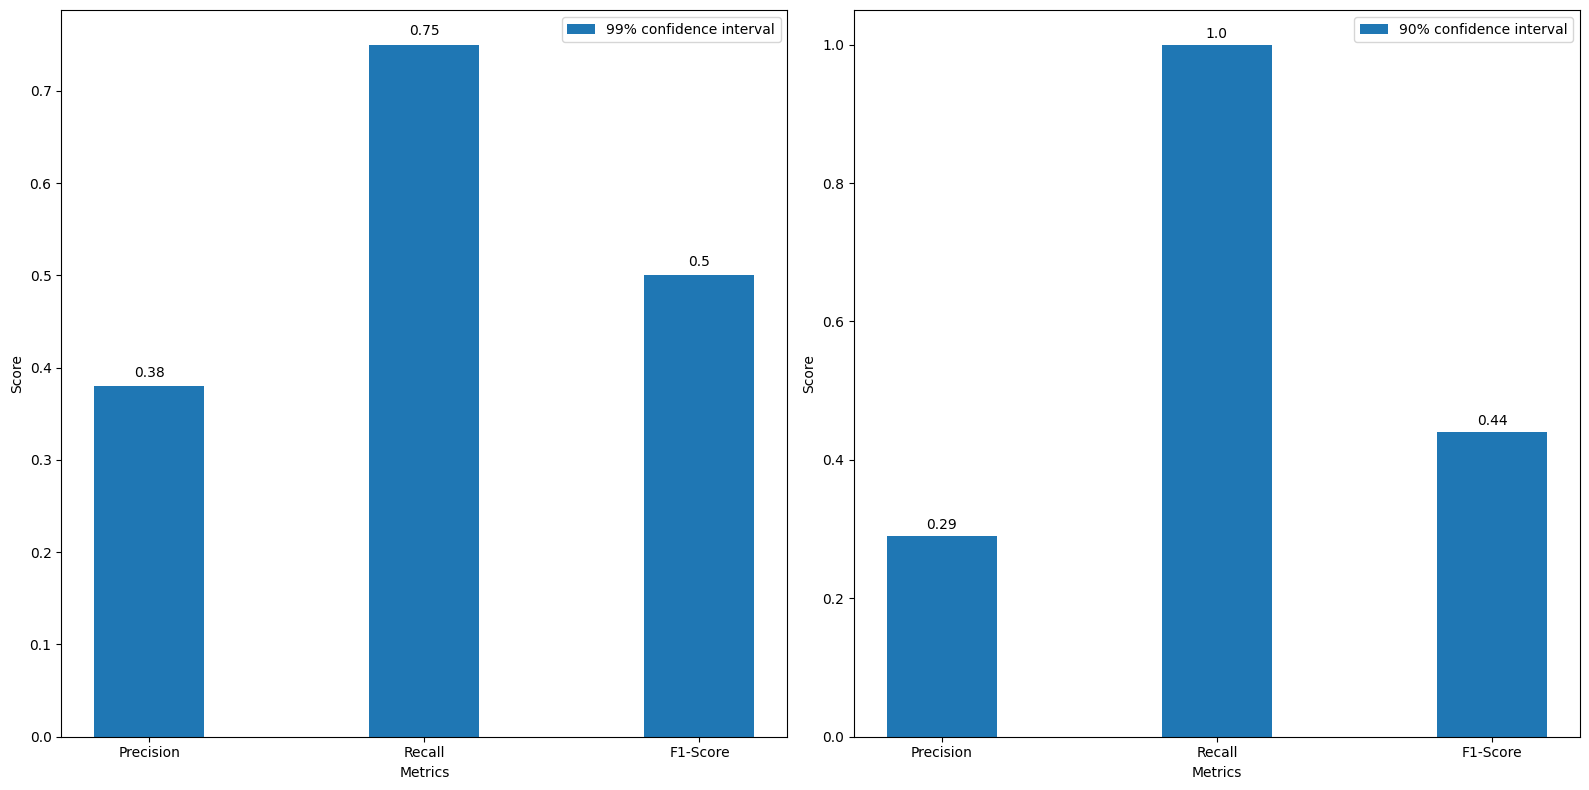

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['Precision', 'Recall', 'F1-Score']
y_99 = [0.38, 0.75, 0.50]
y_90 = [0.29, 1.00, 0.44]

ax1.bar(x, y_99, width=0.4, label='99% confidence interval')
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.legend()

for i, v in enumerate(y_99):
    ax1.text(x=i, y=v+0.01, s=str(v), ha='center')

ax2.bar(x, y_90, width=0.4, label='90% confidence interval')
ax2.set_xlabel('Metrics')
ax2.set_ylabel('Score')
ax2.legend()

for i, v in enumerate(y_90):
    ax2.text(x=i, y=v+.01, s=str(v), ha='center')

plt.tight_layout()
plt.savefig("figures/CH03_codefig11.png", dpi=300)